In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

Using TensorFlow backend.
/home/sezan/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sezan/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sezan/anaconda3/envs/carnd-term1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/se

In [2]:
import tensorflow
from keras.regularizers import l2

In [3]:
SEED = 1

In [4]:
DATA_FOLDER = "../data/Simulator/"

In [5]:
normal = os.path.join(DATA_FOLDER,"CenterLaneDriving")
recovery = os.path.join(DATA_FOLDER,"RecoveryLap")
recovery2 = os.path.join(DATA_FOLDER,"RecoveryLap2")
difficult = os.path.join(DATA_FOLDER,"Difficult")
difficult2 = os.path.join(DATA_FOLDER,"Difficult2")

In [6]:
names = ["Center Image","Left Image","Right Image","Steering", "Throttle", "Brake", "Speed"]

In [7]:
normal_driving_log = pd.read_csv(os.path.join(normal,"driving_log.csv"),names = names)

In [8]:
normal_driving_log.head()

,Center Image,Left Image,Right Image,Steering,Throttle,Brake,Speed
0,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.892318
1,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.811010
2,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.750371
3,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.670085
4,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.128493,0,9.627087


<AxesSubplot:>

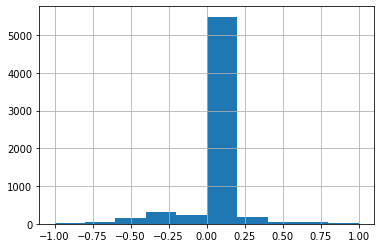

In [9]:
normal_driving_log["Steering"].hist(bins=10)

In [10]:
recovery_driving_log = pd.read_csv(os.path.join(recovery,"driving_log.csv"),names = names)
recovery_driving_log2 = pd.read_csv(os.path.join(recovery2,"driving_log.csv"),names = names)

In [11]:
recovery_driving_log.head()

,Center Image,Left Image,Right Image,Steering,Throttle,Brake,Speed
0,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,3.034396
1,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,3.011356
2,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,2.988503
3,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,2.971483
4,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,2.948949


<AxesSubplot:>

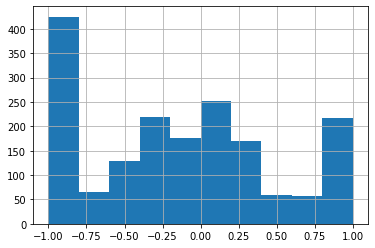

In [12]:
recovery_driving_log[recovery_driving_log["Steering"]!=0.0]["Steering"].hist()

<AxesSubplot:>

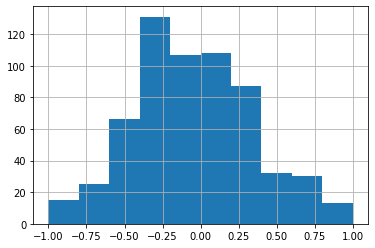

In [13]:
recovery_driving_log2[recovery_driving_log2["Steering"]!=0.0]["Steering"].hist()

In [14]:
recovery_driving_log = recovery_driving_log[recovery_driving_log["Steering"]!=0.0]
recovery_driving_log2 = recovery_driving_log2[recovery_driving_log2["Steering"]!=0.0]

In [15]:
difficult_driving_log =  pd.read_csv(os.path.join(difficult,"driving_log.csv"),names = names)

<AxesSubplot:>

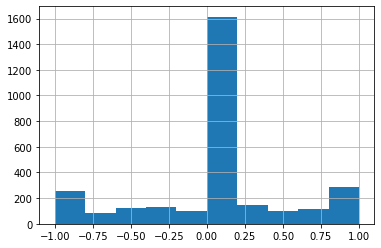

In [16]:
difficult_driving_log["Steering"].hist()

In [17]:
difficult_driving_log2 = pd.read_csv(os.path.join(difficult2,"driving_log.csv"),names = names)

<AxesSubplot:>

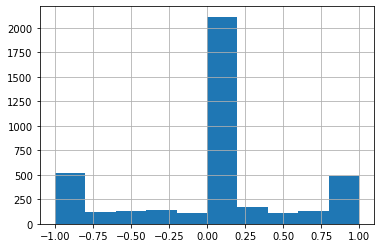

In [18]:
difficult_driving_log2["Steering"].hist()

In [19]:
full_difficult_driving_log = pd.concat([difficult_driving_log,difficult_driving_log2])

In [20]:
data = full_difficult_driving_log[["Center Image","Steering"]]

<AxesSubplot:>

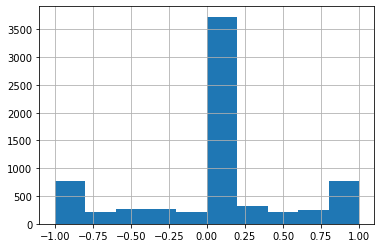

In [21]:
data["Steering"].hist()

In [22]:
data.head()

,Center Image,Steering
0,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0
1,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0
2,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0
3,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0
4,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0


In [23]:
train,test =train_test_split(data)

<AxesSubplot:>

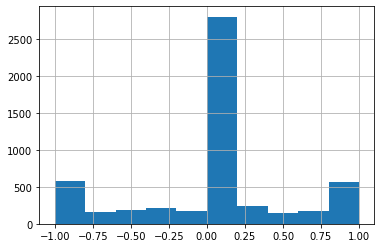

In [24]:
train["Steering"].hist()

<AxesSubplot:>

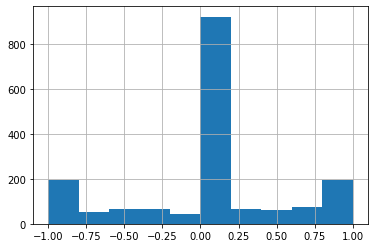

In [25]:
test["Steering"].hist()

In [26]:
np.random.seed(SEED)
from tensorflow import set_random_seed
set_random_seed(SEED)

In [27]:
def resize_image(images,new_size=(128,128)):
    new_image_shape = (images.shape[0],new_size[0],new_size[1],images.shape[3])
    resized_images = np.zeros(shape = new_image_shape)
    for i,image in enumerate(images):
        resized_images[i,:,:,:] = cv2.resize(image,new_size)
    return resized_images

In [28]:
def preprocess(images,new_size=(128,128)):
    images = images[:,60:140,:]
    images = images/255
    images = resize_image(images,new_size)
    return images

In [29]:
def read_images(batch):
    images = [None]*len(batch)
    for i,image_name in enumerate(batch):
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images[i] = image
    images = np.array(images)
    return images
    

In [30]:
def loader(data,batch_size):
    i = 0
    while True:
        batch = data.iloc[i:i+batch_size]
        batch_image_names = batch["Center Image"].values.tolist()
        batch_images = read_images(batch_image_names)
        steering = batch["Steering"].values.tolist()
        i = i+batch_size
        if i>= len(data):
            i = 0
        yield batch_images,steering
            

In [31]:
from keras.models import Sequential

In [32]:
from keras import layers

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [34]:
model = Sequential()
model.add(layers.Lambda(lambda x: x/255.0-0.5, input_shape=(160,320,3)))
model.add(layers.Cropping2D(cropping=((50,20),(0,0))))
model.add(layers.Conv2D(16, (5, 5),strides=(1,1), activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size = 2, strides = 2))
model.add(layers.Conv2D(32, (5, 5), activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(units = 120, activation = 'relu',kernel_regularizer=l2(0.01)))
model.add(layers.Dense(units = 84, activation = 'relu',kernel_regularizer=l2(0.01)))
model.add(layers.Dense(1))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))





Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [35]:
model.compile(optimizer = keras.optimizers.rmsprop(lr=0.0001,rho=0.9),loss = 'mse')

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 16)       1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 316, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 32)       12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 77, 32)        0         
__________

In [37]:
train_loader = loader(train,32)
test_loader = loader(test,32)

In [38]:
history = model.fit_generator(train_loader,steps_per_epoch=len(train)//32,validation_data=test_loader,validation_steps=87,epochs=10,
                              callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                                        ModelCheckpoint('difficult_driving_model.h5', save_best_only=True, monitor='val_loss', mode='min')])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/10
164/164 [==============================] - 66s 399ms/step - loss: 2.8917 - val_loss: 1.9956
Epoch 2/10
164/164 [==============================] - 64s 390ms/step - loss: 1.5753 - val_loss: 1.3227
Epoch 3/10
164/164 [==============================] - 62s 380ms/step - loss: 1.1110 - val_loss: 0.9877
Epoch 4/10
164/164 [==============================] - 63s 381ms/step - loss: 0.8508 - val_loss: 0.7859
Epoch 5/10
164/164 [==============================] - 63s 382ms/step - loss: 0.6783 - val_loss: 0.6373
Epoch 6/10
164/164 [==============================] - 62s 381ms/step - loss: 0.5554 - val_loss: 0.5477
Epoch 7/10
164/164 [==============================] - 64s 392ms/step - loss: 0.4675 - val_loss: 0.4764
Epoch 8/10
164/164 [==============================] - 64s 391ms/step - loss: 0.4073 - val_loss: 0.4198
Epoch 9/10
164/164 [==============================] - 64

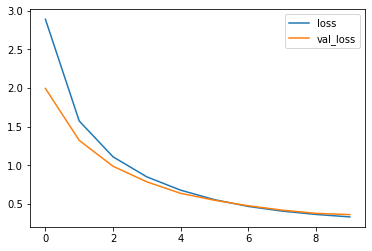

In [39]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
